Here we do bla bla

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
with open(r"./data/spotify_hit_songs.csv", 'r', encoding="utf8") as f:
    df = pd.read_csv(f)

In [5]:
attributes = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']

df_attributes = df[attributes]

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_attributes)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Get the loadings of PC1 and PC2
loadings = pca.components_[:2, :]

# Get the attribute names
attribute_names = df_attributes.columns

# Sort attributes based on loadings
pc1_sorted_attributes = [attribute_names[i] for i in (-loadings[0]).argsort()]
pc2_sorted_attributes = [attribute_names[i] for i in (-loadings[1]).argsort()]

# Create list of attributes with the most variation
selected_attributes = [pc1_sorted_attributes[0], pc2_sorted_attributes[0], pc1_sorted_attributes[1], pc2_sorted_attributes[1]]

# Print the first attribute of PC1 and PC2
print("Attribute 1 primarily represented by PC1:", pc1_sorted_attributes[0])
print("Attribute 1 primarily represented by PC2:", pc2_sorted_attributes[0])
print("Attribute 2 primarily represented by PC1:", pc1_sorted_attributes[1])
print("Attribute 2 primarily represented by PC2:", pc2_sorted_attributes[1])

Attribute 1 primarily represented by PC1: acousticness
Attribute 1 primarily represented by PC2: liveness
Attribute 2 primarily represented by PC1: instrumentalness
Attribute 2 primarily represented by PC2: energy


In [6]:
# Training data and test data
split_percentage = 0.7
split_index = int(len(df) * split_percentage)

df_train = df.iloc[:split_index]
X_train = df_train[selected_attributes]
y_train = df_train['mode'].ravel()

df_test = df.iloc[split_index:]
X_test = df_test[selected_attributes]
y_test = df_test['mode'].ravel()

feature_names_list = X_train.columns.tolist()

Decision Tree Accuracy: 63.74472915990918


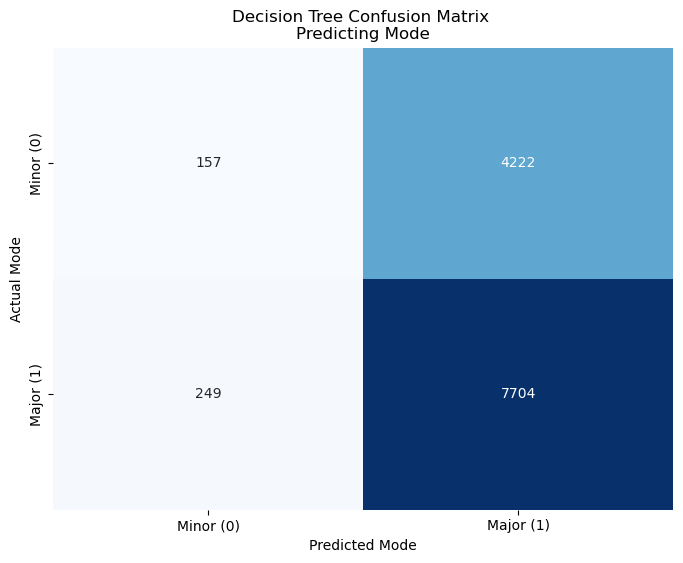

In [38]:
dtc = DecisionTreeClassifier(criterion='gini', min_samples_split=450)
dtc.fit(X_train, y_train)

# Use the trained decision tree model to predict on the test set
dtc_y_pred = dtc.predict(X_test)

# Evaluate accuracy
dtc_accuracy = accuracy_score(y_test, dtc_y_pred)
print(f"Decision Tree Accuracy: {dtc_accuracy*100}")

# Plot the confusion matrix
dtc_conf_matrix = confusion_matrix(y_test, dtc_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(dtc_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'])
plt.title("Decision Tree Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

Isolation Forest Accuracy: 63.177100227051575


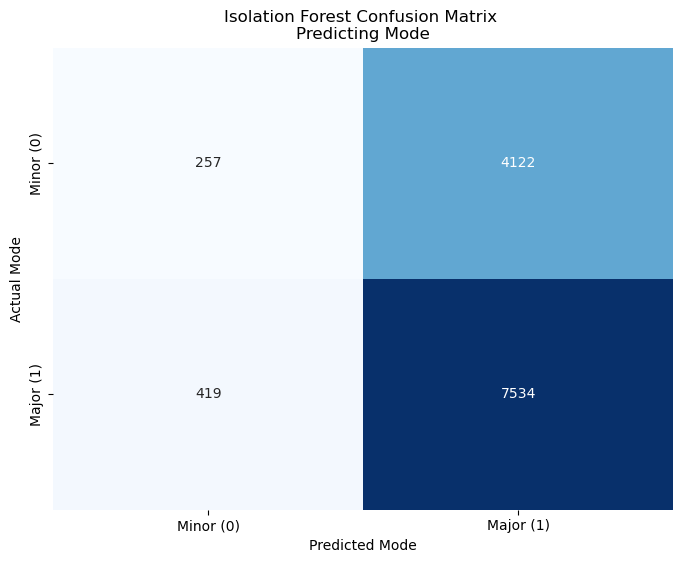

In [39]:
# Create and fit the Isolation Forest model
isof = IsolationForest(contamination=0.05)  # You can adjust the contamination parameter as needed
isof.fit(X_train)

# Use the trained Isolation Forest model to predict on the test set
isof_y_pred = isof.predict(X_test)

# Convert predictions to binary labels (1 for inliers, -1 for outliers)
isof_y_pred_binary = [1 if pred == 1 else 0 for pred in isof_y_pred]

# Evaluate accuracy
isof_accuracy = accuracy_score(y_test, isof_y_pred_binary)
print(f"Isolation Forest Accuracy: {isof_accuracy * 100}")

# Plot the confusion matrix
isof_conf_matrix = confusion_matrix(y_test, isof_y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(isof_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'])
plt.title("Isolation Forest Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

Random Forest Accuracy: 64.47453778786895


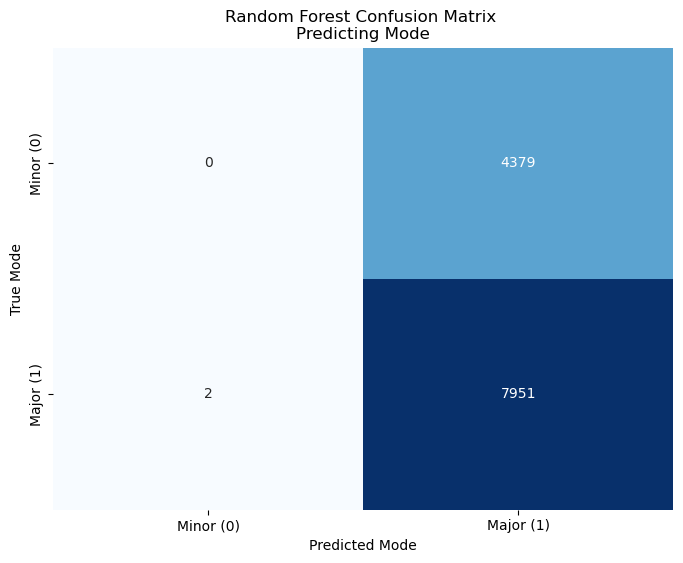

In [40]:
# Create and fit the Random Forest model
rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=450, random_state=42)
rf.fit(X_train, y_train)

# Use the trained Random Forest model to predict on the test set
rf_y_pred = rf.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy * 100}")

# Plot the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Minor (0)', 'Major (1)'], yticklabels=['Minor (0)', 'Major (1)'])
plt.title("Random Forest Confusion Matrix \nPredicting Mode")
plt.xlabel("Predicted Mode")
plt.ylabel("Actual Mode")
plt.show()

Hits in minor: 5548
Hits in major: 15005
Flops in minor: 7057
Flops in major: 13496


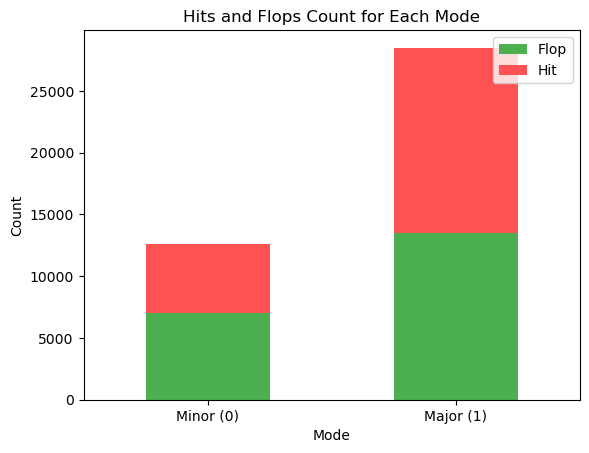

In [41]:
# Group the data by 'mode' and 'target' and count the occurrences
mode_target_counts = df.groupby(['mode', 'target']).size().unstack(fill_value=0)

# Print the counts of hits and flops for each mode
hits_mode_0 = mode_target_counts.loc[0, 1]
hits_mode_1 = mode_target_counts.loc[1, 1]
flops_mode_0 = mode_target_counts.loc[0, 0]
flops_mode_1 = mode_target_counts.loc[1, 0]

print(f"Hits in minor: {hits_mode_0}")
print(f"Hits in major: {hits_mode_1}")
print(f"Flops in minor: {flops_mode_0}")
print(f"Flops in major: {flops_mode_1}")

# Plot the histogram
mode_target_counts.plot(kind='bar', stacked=True, color=['#4CAF50', '#FF5252'])
plt.title('Hits and Flops Count for Each Mode')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.legend(['Flop', 'Hit'], loc='upper right')
plt.xticks(ticks=[0, 1], labels=['Minor (0)', 'Major (1)'], rotation=0)

plt.show()

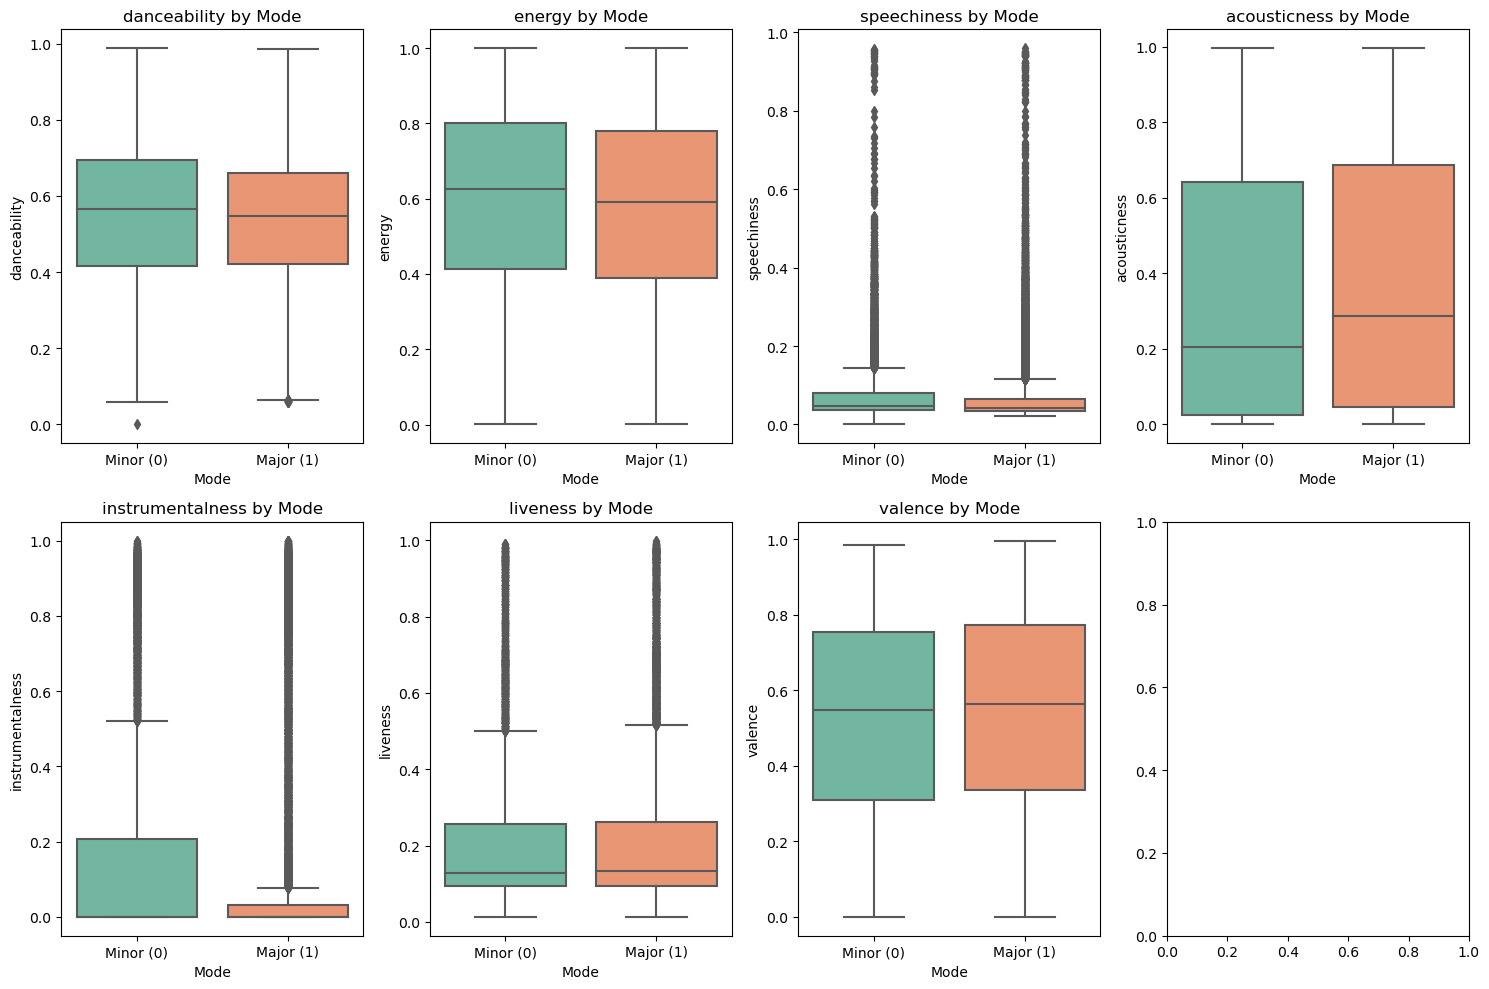

In [13]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes = axes.flatten()

# Plot boxplots for each attribute grouped by 'mode'
for i, attribute in enumerate(attributes):
    sns.boxplot(x='mode', y=attribute, data=df, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{attribute} by Mode')
    axes[i].set_xlabel('Mode')
    axes[i].set_ylabel(attribute)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Minor (0)', 'Major (1)'])

plt.tight_layout()
plt.show()